In [ ]:
!pip install pyLDAvis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df_AAMI = pd.read_excel("CarInsurance_reviews.xlsx", sheet_name='AAMI')
df_Allianz  = pd.read_excel("CarInsurance_reviews.xlsx", sheet_name='Allianz')
df_bingle =  pd.read_excel("CarInsurance_reviews.xlsx", sheet_name='Bingle')
df_racv = pd.read_excel("CarInsurance_reviews.xlsx", sheet_name='RACV')

In [ ]:
df_bingle.columns

Index(['title', 'review', 'date', 'stars'], dtype='object')

In [5]:
df_AAMI= df_AAMI[['date','review']]
df_Allianz= df_Allianz[['date','review']]
df_bingle= df_bingle[['date','review']]
df_racv= df_racv[['date','review']]

In [6]:
df_AAMI['provider']='AAMI'
df_Allianz['provider']='Allianz'
df_bingle['provider']='Bingle'
df_racv['provider']='RACV'

In [ ]:
df_AAMI.head()

In [7]:
df = pd.concat([df_AAMI, df_Allianz,df_bingle,df_racv], ignore_index=True)

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date

In [9]:
df['review'] = df['review'].str.lower()

In [ ]:
df.tail()

,date,review,provider
635,2018-11-18,ive many many years one stage paying well 100 ...,RACV
636,2018-11-12,husband received letter end october offering i...,RACV
637,2018-11-10,using last 3 years came back intent use compan...,RACV
638,2018-11-08,since 2010 deteriorating service year since 20...,RACV
639,2018-10-28,good eveningi called insurance claim fault lit...,RACV


In [10]:
duplicate_count = len(df['review'])-len(df['review'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 0
total records before remove duplicates: 640


In [11]:
df['review'] = df['review'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.tail()

,date,review,provider
635,2018-11-18,ive been with racv for many many years at one ...,RACV
636,2018-11-12,my husband received a letter from racv at the ...,RACV
637,2018-11-10,was using racv for last 3 years just came back...,RACV
638,2018-11-08,been with racv since 2010 deteriorating servic...,RACV
639,2018-10-28,good eveningi called in for a insurance claim ...,RACV


In [12]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [14]:
stop.remove('not')

In [15]:
# Remove the words in 'stop' list
def remove_stop_words(reviews):
  tokens = reviews.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['review'] = df['review'].apply(remove_stop_words)
df.tail(5)

,date,review,provider
635,2018-11-18,ive racv many many years one stage paying well...,RACV
636,2018-11-12,husband received letter racv end october offer...,RACV
637,2018-11-10,using racv last 3 years came back intent use c...,RACV
638,2018-11-08,racv since 2010 deteriorating service year sin...,RACV
639,2018-10-28,good eveningi called insurance claim fault lit...,RACV


In [16]:
word_frequency = pd.Series(' '.join(df['review']).split()).value_counts()

In [ ]:
word_frequency[:10]

not          368
claim        281
insurance    279
policy       200
service      159
get          155
years        145
company      139
call         132
time         127
dtype: int64

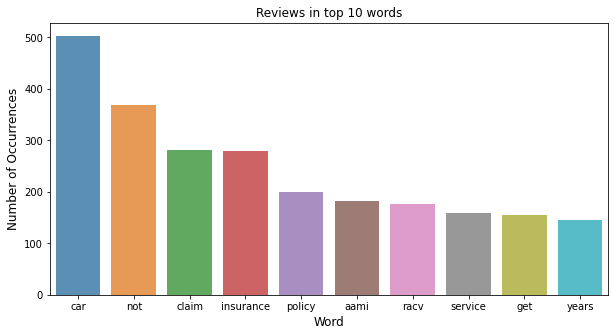

In [17]:
word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Reviews in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

In [18]:
from PIL import Image
from wordcloud import WordCloud

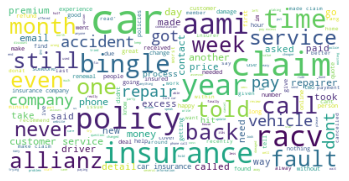

In [19]:
corpus = list(df['review'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
new_words_to_remove = ["car", "aami", "racv", "bingle", "allianz","would","get"]

In [ ]:
word_frequency

In [21]:
df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,date,review,provider
0,2020-09-01,13 months refused admit flooded couldnt repair...,AAMI
1,2020-08-30,âœhere blue must give way orangeâ,AAMI
2,2020-08-27,last 5 6 years could always helpful great road...,AAMI
3,2020-08-21,years ago claimed repairs always took longer e...,AAMI
4,2020-08-20,currently customer looking new insurance premi...,AAMI


In [ ]:
df_AAMI_processed = df.loc[df['provider'] == 'AAMI']
df_allianz_processed = df.loc[df['provider'] == 'Allianz']
df_bingle_processed = df.loc[df['provider'] == 'Bingle']
df_racv_processed = df.loc[df['provider'] == 'RACV']

In [23]:
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

In [24]:
bigrams_df = get_ngrams(df['review'].tolist(), ngram_range=(2, 2))

In [26]:
#converting the bigrams to a dataframe
bigramsdf = pd.DataFrame(bigrams_df)
bigramsdf.columns=["Bi-gram", "Freq"]

In [ ]:
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigramsdf[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Bigram Analysis')
plt.show()

In [28]:
trigrams_df = get_ngrams(df['review'].tolist(), ngram_range=(3, 3))

In [29]:
#converting trigrams into a dataframe
trigramsdf = pd.DataFrame(trigrams_df)
trigramsdf.columns=["Tri-gram", "Freq"]

In [ ]:
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigramsdf[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Trigram Analysis')
plt.show()


In [32]:
df_date_wise = df.groupby(['date'])['review'].count().reset_index(name='review_count_df')

In [ ]:
df_date_wise.tail()

In [33]:
df_date_wise['date'] = pd.to_datetime(df_date_wise['date'])

In [34]:
reviews_month = df_date_wise.groupby(df_date_wise['date'].dt.strftime("%Y-%m"))['review_count_df'].sum()

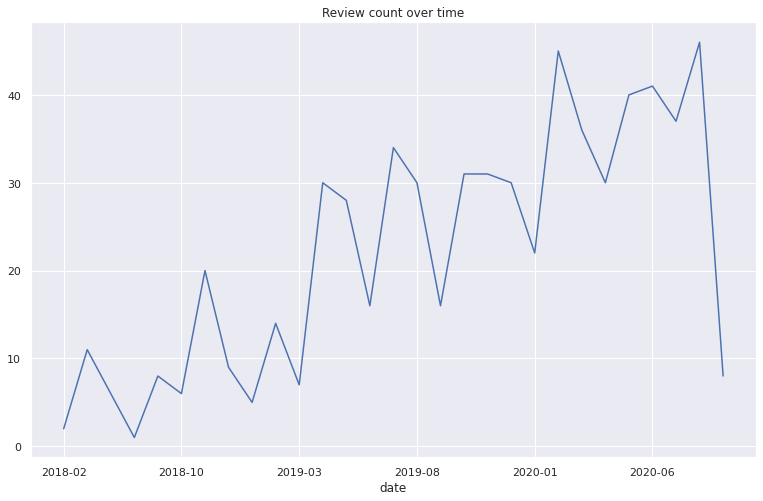

In [35]:
ax = reviews_month.plot()
plt.title('Review count over time')
plt.savefig('temporal_analysis_v2.png', dpi=800)

In [36]:
df['sentiment'] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [45]:
dfsentiment = df[['date','sentiment']]

In [ ]:
dfsentiment['date'] = pd.to_datetime(dfsentiment['date'])

In [48]:
df_sentiment = dfsentiment.groupby(dfsentiment['date'].dt.strftime("%Y-%m"))['sentiment'].mean()

Text(0.5, 1.0, 'Sentiment over time')

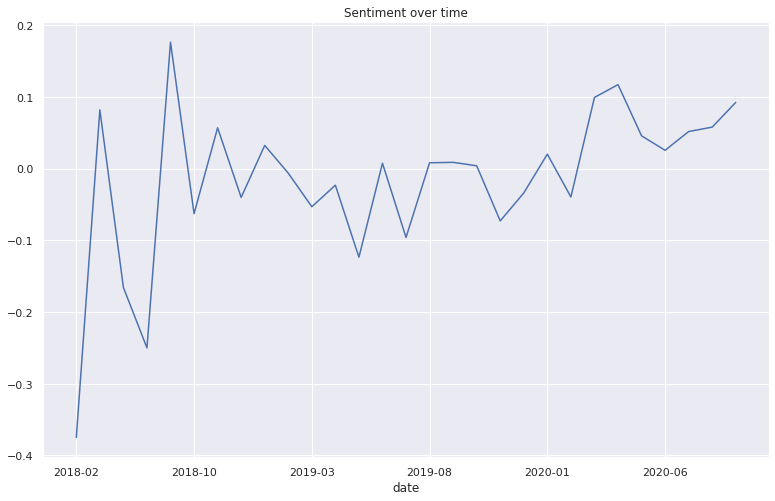

In [49]:
#plt.figure(figsize=(10, 4))
ax = df_sentiment.plot()
plt.title('Sentiment over time')

In [ ]:
dfsentiment['date'] = pd.to_datetime(dfsentiment['date'])

In [50]:
mask = (dfsentiment['date'] >= '2020-01-01') & (dfsentiment['date'] <= '2020-03-31')

In [51]:
sentiment_JanMarch2020 = dfsentiment.loc[mask]

In [69]:
sentiment_analysis = sentiment_JanMarch2020.groupby(sentiment_JanMarch2020['date'].dt.strftime("%b-%d"))['sentiment'].mean()

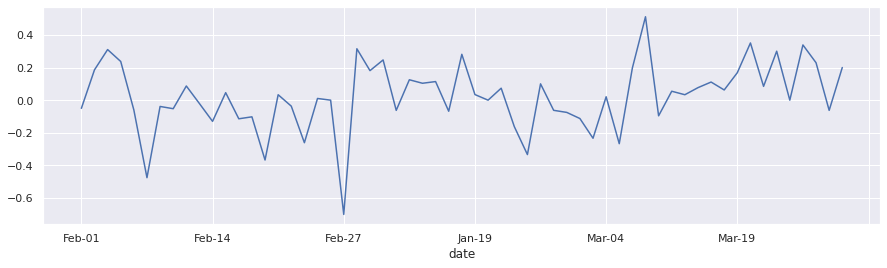

In [70]:
plt.figure(figsize=(15, 4))
ax = sentiment_analysis.plot()

In [ ]:
df[['review', 'sentiment']].head(50)

In [ ]:
TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [ ]:
corpus = list(df['review'])

In [ ]:
df_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
dictionary = corpora.Dictionary(df_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'df.dict'))

In [ ]:
print(df_texts[0])
print('alphabetically sorted', sorted(df_texts[0]))

In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'13': 0, '703903': 1, '9': 2, 'act': 3, 'admit': 4, 'afca': 5, 'assess': 6, 'call': 7, 'cannot': 8, 'comply': 9, 'conspire': 10, 'couldnt': 11, 'defence': 12, 'determination': 13, 'distress': 14, 'flooded': 15, 'forced': 16, 'human': 17, 'im': 18, 'job': 19, 'last': 20, 'laughing': 21, 'like': 22, 'lookup': 23, 'lost': 24, 'make': 25, 'manufacturers': 26, 'may': 27, 'months': 28, 'mount': 29, 'people': 30, 'privacy': 31, 'recordings': 32, 'refused': 33, 'repaired': 34, 'scrap': 35, 'sick': 36, 'silly': 37, 'sure': 38, 'telling': 39, 'treat': 40, 'trust': 41, 'twisted': 42, 'update': 43, 'week': 44, 'blue': 45, 'give': 46, 'must': 47, 'orangeâ': 48, 'way': 49, 'âœhere': 50, '5': 51, '6': 52, 'always': 53, 'appreciated': 54, 'assistance': 55, 'claims': 56, 'could': 57, 'deal': 58, 'discount': 59, 'even': 60, 'gave': 61, 'great': 62, 'helpful': 63, 'lodged': 64, 'much': 65, 'pressure': 66, 'roadside': 67, 'take': 68, 'times': 69, 'toughs': 70, 'work': 71, 'years': 72, 'ago': 73, 'around'

In [ ]:
corpus = [dictionary.doc2bow(text) for text in df_texts]

In [ ]:
review_id = 0
print(df_texts[review_id]) # each tweet converted to tokens
print(dictionary.doc2bow(df_texts[review_id])) # each token is represented as a id from a dictionary

['13', 'months', 'refused', 'admit', 'flooded', 'couldnt', 'repaired', 'forced', 'scrap', 'last', 'week', 'afca', 'lookup', 'afca', 'determination', '703903', '9', '13', 'months', 'lost', 'job', 'people', 'sick', 'twisted', 'laughing', 'distress', 'call', 'recordings', 'telling', 'im', 'silly', 'cannot', 'trust', 'assess', 'treat', 'like', 'human', 'cannot', 'trust', 'update', 'cannot', 'trust', 'comply', 'privacy', 'act', 'may', 'conspire', 'manufacturers', 'make', 'sure', 'cannot', 'mount', 'defence']
[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 4), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1)]


In [ ]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

In [ ]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus]

In [ ]:
total_topics = 15

In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      32.420952   8.115230       1        1  45.606033
5       0.648955  71.707100       2        1  12.175385
6      71.019684   9.971006       3        1   7.021336
4       3.785981  33.185135       4        1   5.120165
9     -42.666500  -9.222070       5        1   5.074483
0      -3.621689 -43.526516       6        1   5.000871
3      -3.632402  -4.171708       7        1   5.000704
8     -36.584400  35.804413       8        1   5.000593
7      44.391380  50.615383       9        1   5.000241
2      40.235809 -31.591665      10        1   5.000197, topic_info=          Term      Freq     Total Category  logprob  loglift
107        not  8.000000  8.000000  Default  30.0000  30.0000
101  insurance  7.000000  7.000000  Default  29.0000  29.0000
127      claim  7.000000  7.000000  Default  28.0000  28.0000
161     policy  5.000000  5.000000  Default  27.0000  27.0000
205    service  3.000000  3.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
340    company  0.122172  3.462821  Topic10  -5.5681  -0.3487
82       still  0.108814  2.573622  Topic10  -5.6839  -0.1677
295   accident  0.106278  1.976984  Topic10  -5.7075   0.0724
56      claims  0.106434  2.405251  Topic10  -5.7060  -0.1222
125       back  0.104758  2.308071  Topic10  -5.7219  -0.0968

[820 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
153       1  0.497841         2
90        1  0.483068         3
90        2  0.483068         3
295       1  0.505821  accident
178       1  1.288959    almost
...     ...       ...       ...
49        1  0.568084       way
454       1  0.557792     weeks
214       1  0.530587      year
72        1  0.545873     years
72        2  0.272937     years

[85 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 7, 5, 10, 1, 4, 9, 8, 3])